# EDA

### Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest

import warnings
warnings.filterwarnings("ignore")

class display(object):
    """Representador HTML de múltiples objetos"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

---

### 1. Carga de datos

In [2]:
# USAMOS DE BASE EL CONJUNTO DE DATOS YA LIMPIO
df_base = pd.read_csv('../data/processed/data_processed_1990_2023.csv', index_col='fecha')
df_base.drop('target', axis=1, inplace=True)
df_base.index = pd.to_datetime(df_base.index)
df_base.tail(7)

,tmin,tmax,tmed,presMin,presMax,dir,velmedia,racha,sol,prec
fecha,,,,,,,,,,
2023-03-06,10.3,15.9,13.1,1008.7,1013.4,21.0,1.9,8.3,0.0,3.3
2023-03-07,12.9,19.7,16.3,1009.8,1013.4,22.0,3.9,10.3,3.2,0.6
2023-03-08,14.4,20.5,17.4,1011.6,1015.1,22.0,6.1,10.3,3.2,2.5
2023-03-09,13.6,20.5,17.0,1013.7,1019.5,21.0,5.3,12.5,3.0,0.9
2023-03-10,8.9,21.8,15.4,1019.2,1022.5,99.0,1.7,6.7,10.5,0.1
2023-03-11,8.9,24.0,16.4,1018.7,1022.2,99.0,2.8,7.8,9.9,0.0
2023-03-12,9.5,26.5,18.0,1014.1,1020.3,8.0,2.2,8.3,10.6,0.0


In [3]:
df_base.describe()

,tmin,tmax,tmed,presMin,presMax,dir,velmedia,racha,sol,prec
count,12124.000000,12124.000000,12124.000000,12124.000000,12124.000000,12124.000000,12124.000000,12124.000000,12124.000000,12124.000000
mean,13.317580,25.745841,19.532211,1011.682097,1015.896893,28.847668,3.005856,9.752408,8.459183,1.417540
std,5.909519,7.859873,6.678616,5.972204,5.510790,28.194490,1.575028,3.179852,3.748499,5.199497
min,-4.000000,4.000000,2.700000,976.300000,986.800000,1.000000,0.000000,1.900000,0.000000,0.000000
25%,8.600000,18.900000,13.900000,1008.300000,1012.300000,9.000000,1.900000,7.800000,6.300000,0.000000
50%,13.400000,25.000000,19.000000,1010.900000,1015.000000,22.000000,2.800000,9.400000,9.300000,0.000000
75%,18.400000,32.400000,25.300000,1014.900000,1019.200000,27.000000,3.900000,11.400000,11.400000,0.000000
max,29.300000,46.600000,36.800000,1035.400000,1038.000000,99.000000,12.800000,31.900000,14.400000,109.300000


---

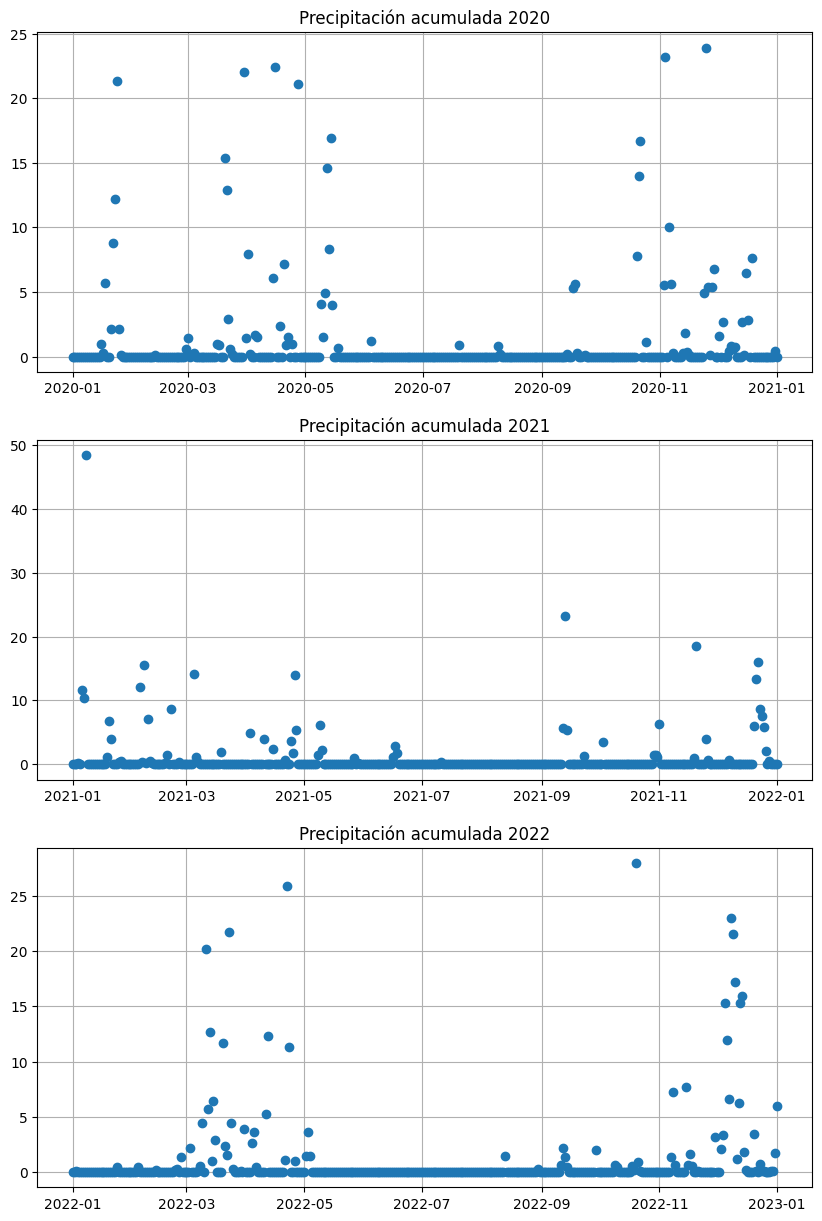

<Figure size 2500x1500 with 0 Axes>

In [4]:
ts2020,ts2021,ts2022 = df_base['prec']['2020-01-01':'2021-01-01'],df_base['prec']['2021-01-01':'2022-01-01'],df_base['prec']['2022-01-01':'2023-01-01'],
figs,ax =  plt.subplots(3,figsize=(10,15))

plt.figure(figsize=(25, 15))
ax[0].plot(ts2020,'o')
ax[0].set_title('Precipitación acumulada 2020')
ax[0].grid(True)
ax[1].plot(ts2021,'o')
ax[1].set_title('Precipitación acumulada 2021')
ax[1].grid(True)
ax[2].plot(ts2022,'o')
ax[2].set_title('Precipitación acumulada 2022')
ax[2].grid(True)

plt.show()

### 2. Análisis

#### 2.1 - Correlaciones

In [5]:
corr = np.abs(df_base.corr()['prec']).sort_values(ascending=True)
print(corr)

dir         0.022748
tmin        0.062669
tmed        0.164669
velmedia    0.175281
tmax        0.232696
presMax     0.256066
racha       0.308109
presMin     0.321889
sol         0.426965
prec        1.000000
Name: prec, dtype: float64


interval columns not set, guessing: ['tmin', 'tmax', 'tmed', 'presMin', 'presMax', 'dir', 'velmedia', 'racha', 'sol', 'prec']


<AxesSubplot:>

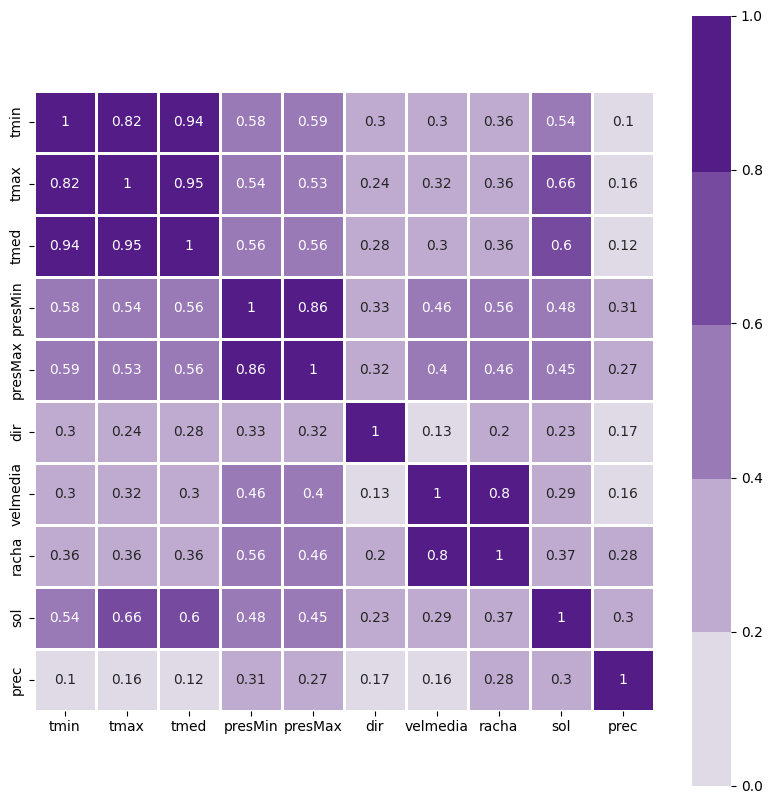

In [6]:
phik_matrix = df_base.phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(phik_matrix,
            vmin=0,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=1)


- Las mayores correlaciones se dan entre:
    - Rachas de viento y velocidad media del mismo.
    - Temperaturas mínimas, máximas y medias.
    - Presión mínima y máxima.

- Son unos resultados bastante obvios.

#### 2.2 - Feature importance

In [7]:
# USANDO RANDOM FOREST
X = df_base.iloc[:,:-1]
Y = df_base['prec']
names = df_base.columns

rf = RandomForestRegressor(n_estimators = 250)
rf.fit(X, Y)

scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

,Score,Feature
0,0.2747,sol
1,0.2247,presMin
2,0.1104,racha
3,0.0749,presMax
4,0.0686,tmax
5,0.0680,dir
6,0.0661,tmin
7,0.0647,velmedia
8,0.0479,tmed


- Los más relevantes según RF son la radiación solar y la presión atmosférica mínima.
- La presión atmosférica baja cuando se acerca un frente lluvioso, por lo que parece bastante revelador este feature.

In [8]:
# USANDO SELECT K BEST
print(X.shape)
sel = SelectKBest(k=5)
X_new = sel.fit_transform(X, Y)
print(X_new.shape)
print(sel.scores_)
names = X.columns

pd.DataFrame({'column': names, 'score': sel.scores_}).sort_values('score', ascending=False)


(12124, 9)
(12124, 5)
[ 1.01654759  4.44979044  2.56451319  5.18772801  3.44744473  0.91673561
  2.75725829  5.52874251 16.44491764]


,column,score
8,sol,16.444918
7,racha,5.528743
3,presMin,5.187728
1,tmax,4.449790
4,presMax,3.447445
6,velmedia,2.757258
2,tmed,2.564513
0,tmin,1.016548
5,dir,0.916736


- SelectKBest nos ratifica lo que veíamos sobre la radiación solar, aunque también da importancia a las rachas de viento. 
- Ante cambios rápidos de presión atmosférica, se dan mayores rachas de viento, por lo que sigue teniendo sentido.

#### 3 - Analisis del target 

<AxesSubplot:title={'center':'Precipitación acumulada'}, xlabel='fecha'>

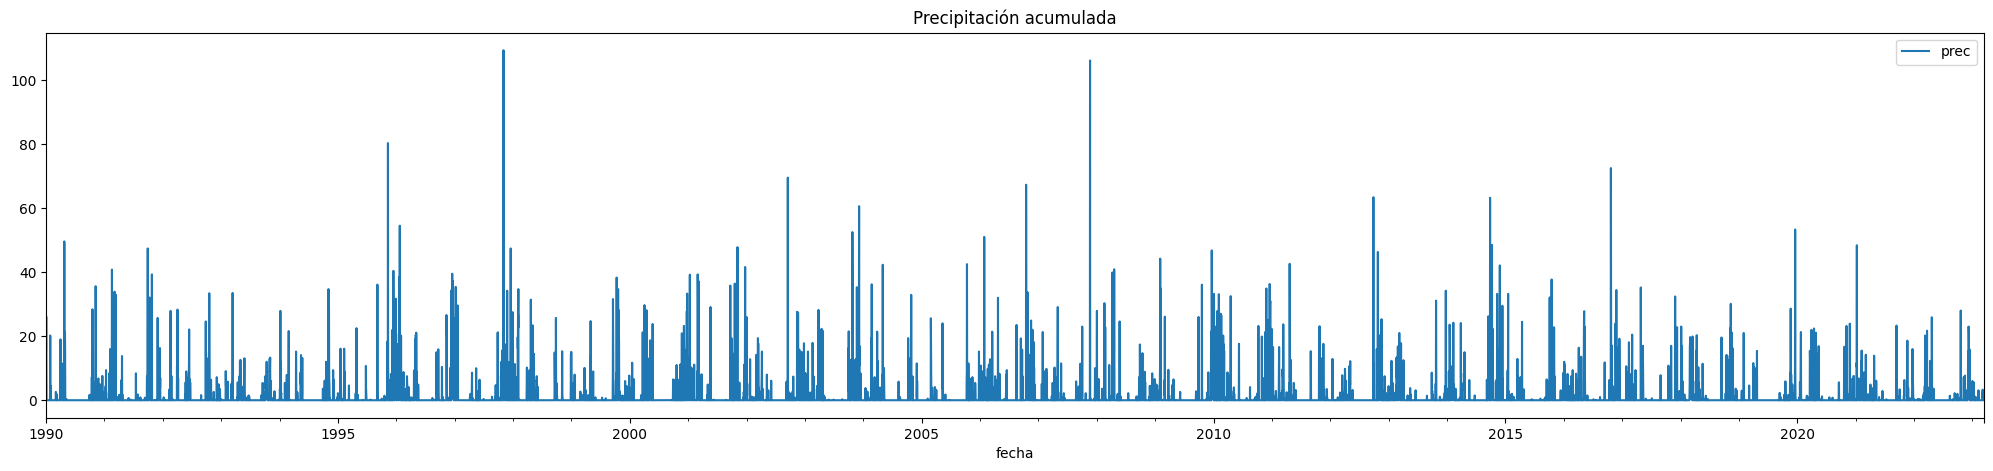

In [9]:
df_base.plot(y='prec', title='Precipitación acumulada', figsize=(25, 5))

<AxesSubplot:title={'center':'Precipitación acumulada'}, xlabel='fecha'>

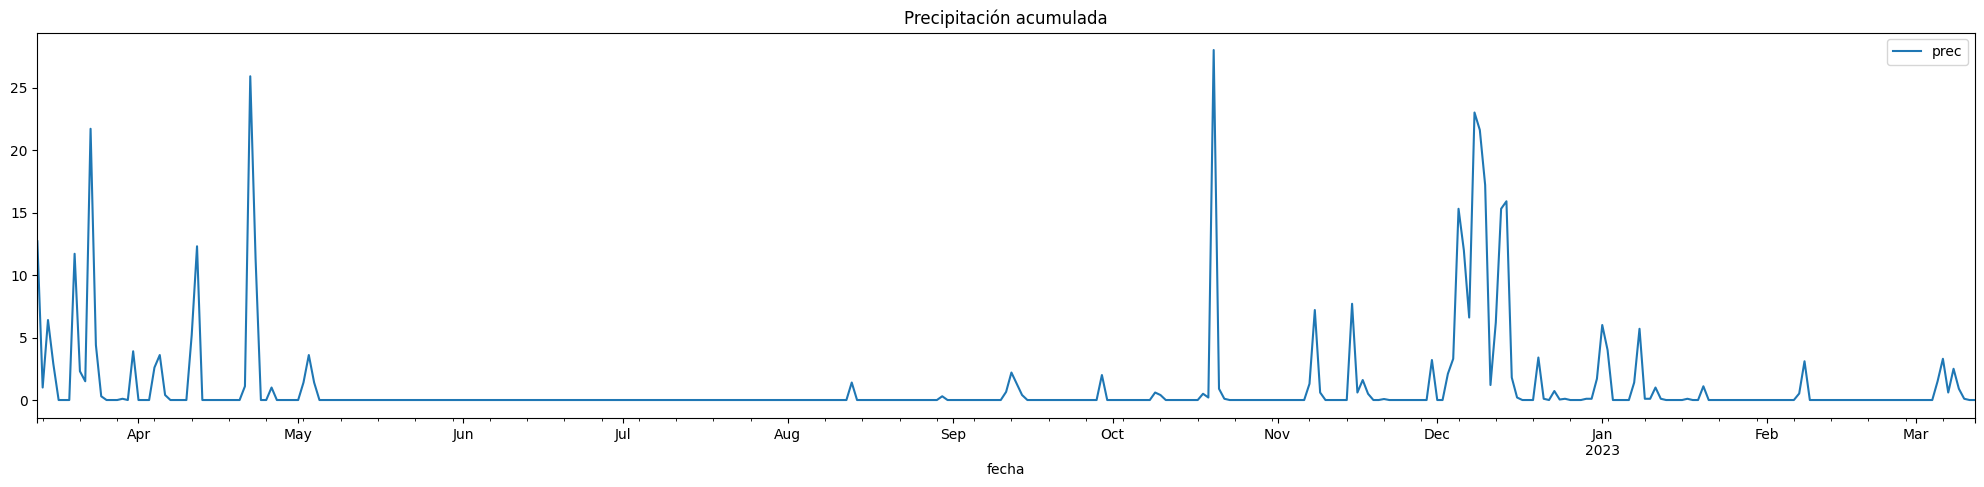

In [10]:
df_last365 = df_base.iloc[-365:]
df_last365.plot(y='prec', title='Precipitación acumulada', figsize=(25, 5))

- Outliers

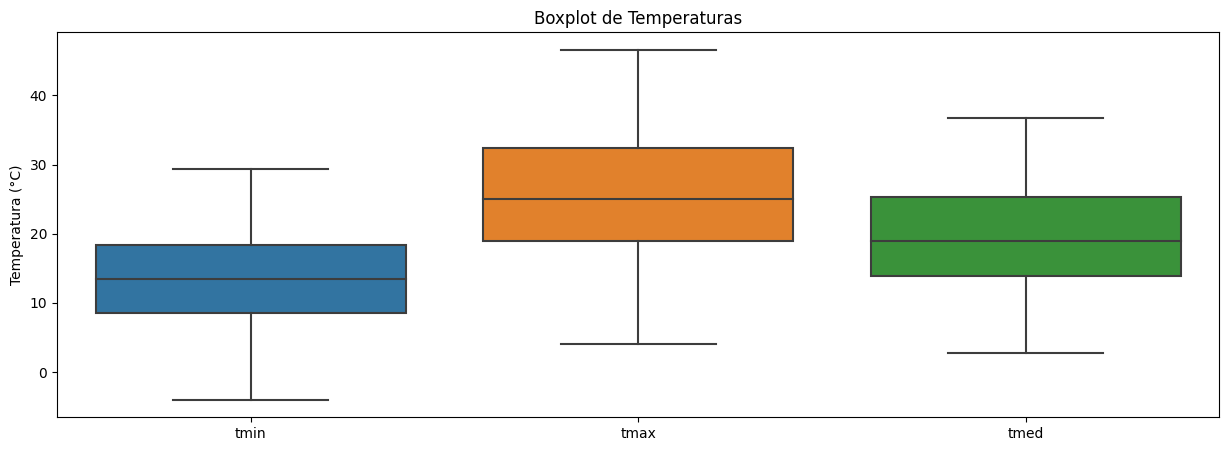

In [11]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 1, 1)
sns.boxplot(data=df_base[['tmin', 'tmax', 'tmed']], ax=ax)

ax.set_ylabel('Temperatura (°C)')
ax.set_title('Boxplot de Temperaturas')

plt.show()

<AxesSubplot:>

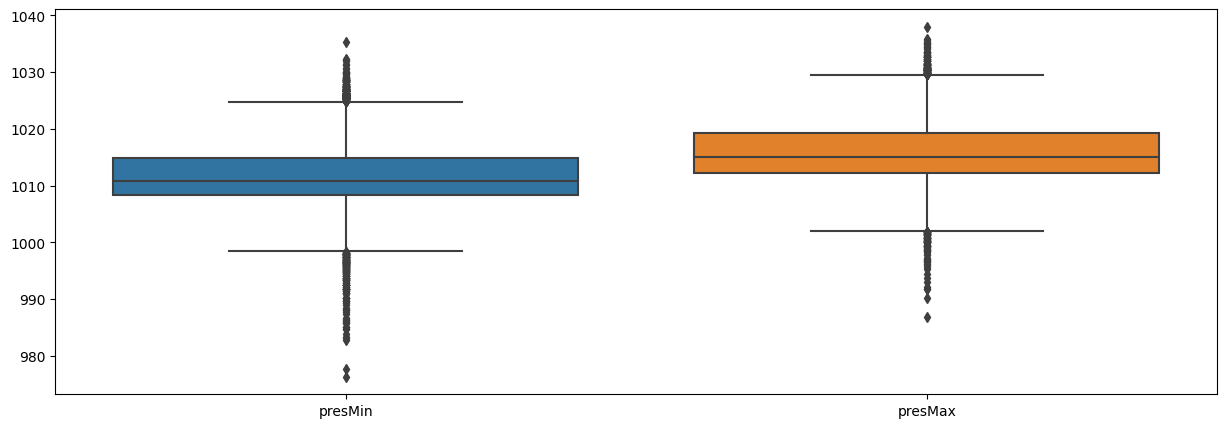

In [12]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df_base[['presMin', 'presMax']])

<AxesSubplot:>

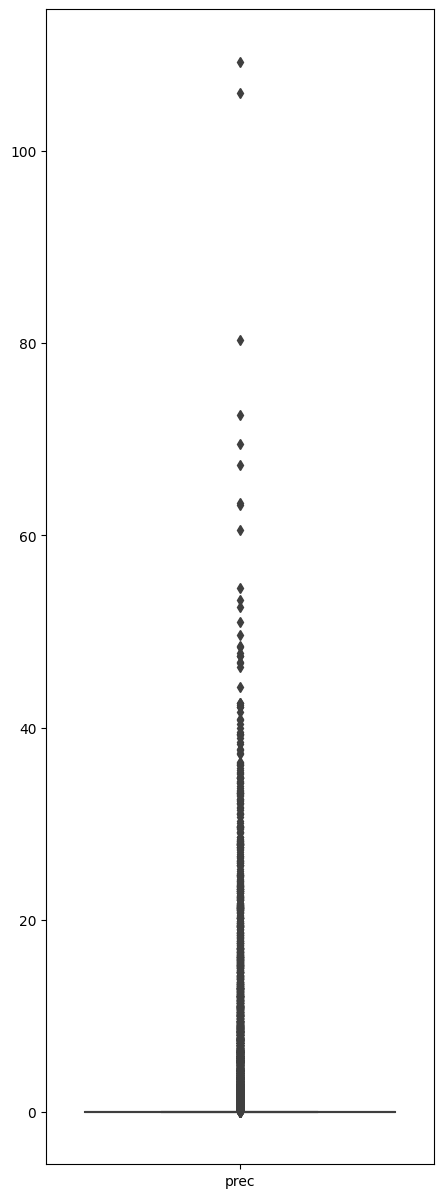

In [13]:
plt.figure(figsize=(5, 15))
sns.boxplot(data=df_base[['prec']])

- Histograma

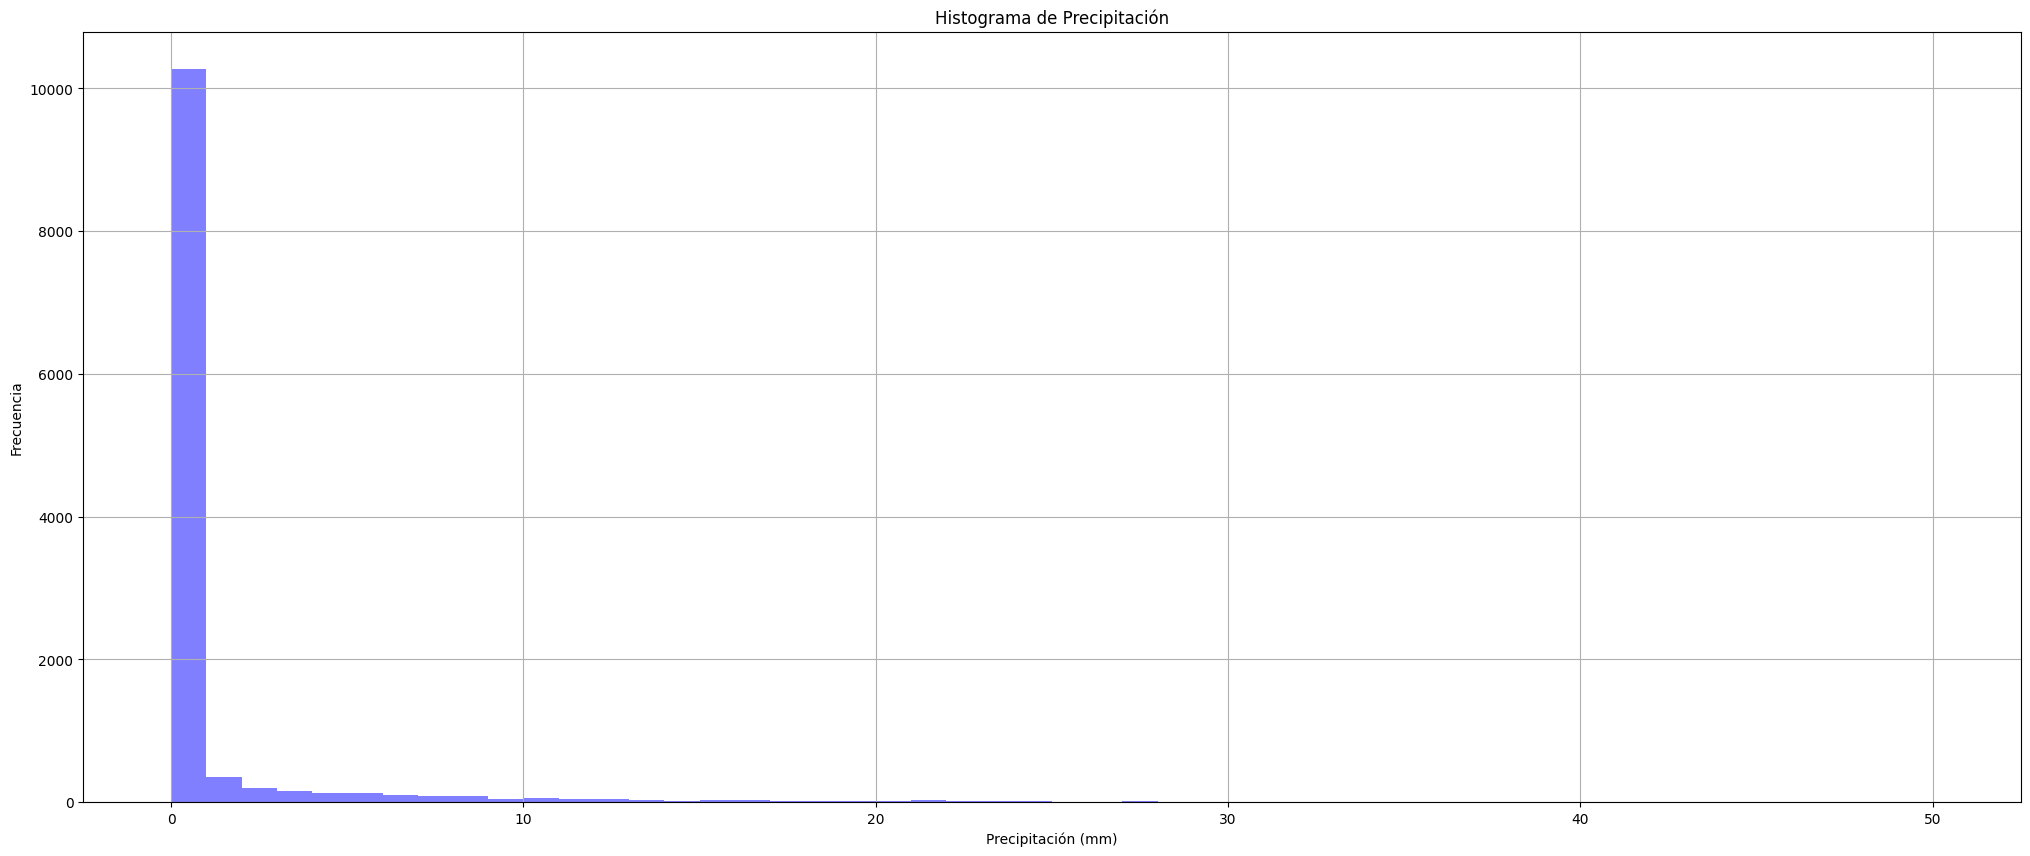

In [14]:
fig, ax = plt.subplots(figsize=(25, 10))
df_base["prec"].hist(ax=ax, bins=50, range=[0, 50], color='blue', alpha=0.5)
ax.set_title('Histograma de Precipitación')
ax.set_xlabel('Precipitación (mm)')
ax.set_ylabel('Frecuencia')
plt.show()